In [ ]:
import numpy as np
import os
import tensorflow as tf
print("GPU是否可用:", tf.config.list_physical_devices('GPU'))
# 1. 首先挂载云端硬盘
from google.colab import drive
drive.mount('/content/drive')

# 2. 查看 MyDrive 目录下有什么
print("MyDrive目录内容：")
!ls '/content/drive/MyDrive'
# 加载数据
data = np.load('/content/drive/MyDrive/archive/scut_fbp5500-cmprsd.npz')


In [ ]:
images, labels = data.files

In [ ]:
data[images].shape

(5500, 350, 350, 3)

In [ ]:
data[labels].shape

(5500,)

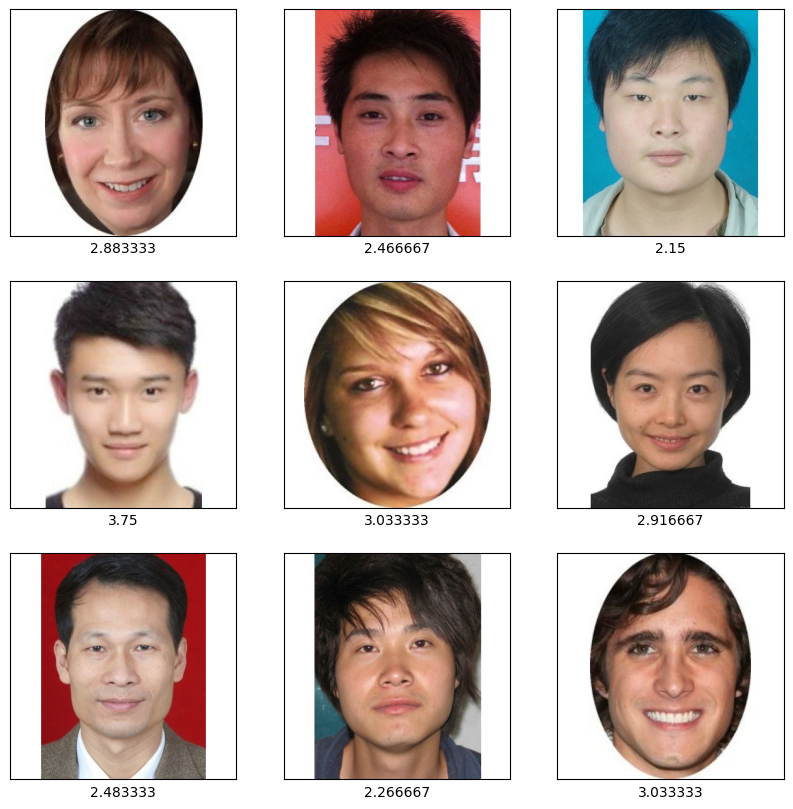

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(data["X"][i])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(data["y"][i])
plt.show()

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
# 拆分训练集和测试集
X = data["X"]
y = data["y"]

X_resized = tf.image.resize(X, (224, 224))
X = X_resized.numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 将数据标准化
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [ ]:
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train dtype: float32
y_train dtype: float32
X_train shape: (4400, 224, 224, 3)
y_train shape: (4400,)


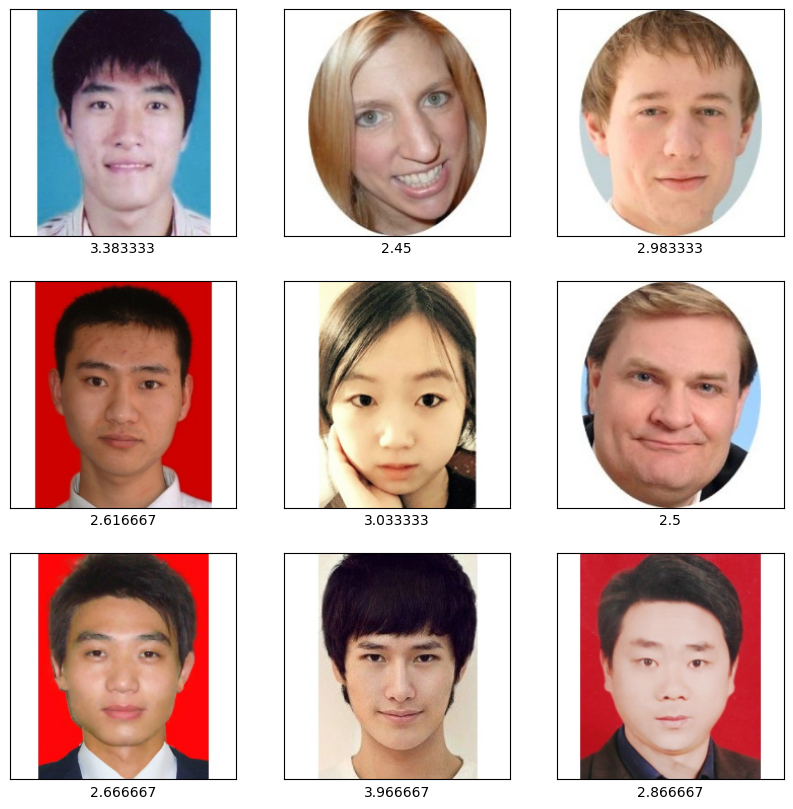

In [ ]:
plt.figure(figsize=(10,10))

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(X_train[i])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(y_train[i])
plt.show()

In [ ]:
# 构建模型
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mse",
              metrics=["mae"],
              jit_compile=True
)

In [ ]:
# 训练模型
model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 322ms/step - loss: 3.7538 - mae: 1.5077
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - loss: 0.4567 - mae: 0.5422
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - loss: 0.3254 - mae: 0.4511
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - loss: 0.3186 - mae: 0.4477
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - loss: 0.2660 - mae: 0.4019
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - loss: 0.2538 - mae: 0.3940
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - loss: 0.2263 - mae: 0.3685
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - loss: 0.2089 - mae: 0.3548
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 0.2016 - mae: 0.3522
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 0.1936 - mae: 0.3429


In [ ]:
# 评估模型
model.evaluate(X_test, y_test, verbose=2)

35/35 - 1s - 16ms/step - loss: 0.2800 - mae: 0.4088


[0.27996164560317993, 0.408849835395813]

In [ ]:
# 1. 预测测试集
test_predictions = model.predict(X_test)



35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2.8882089

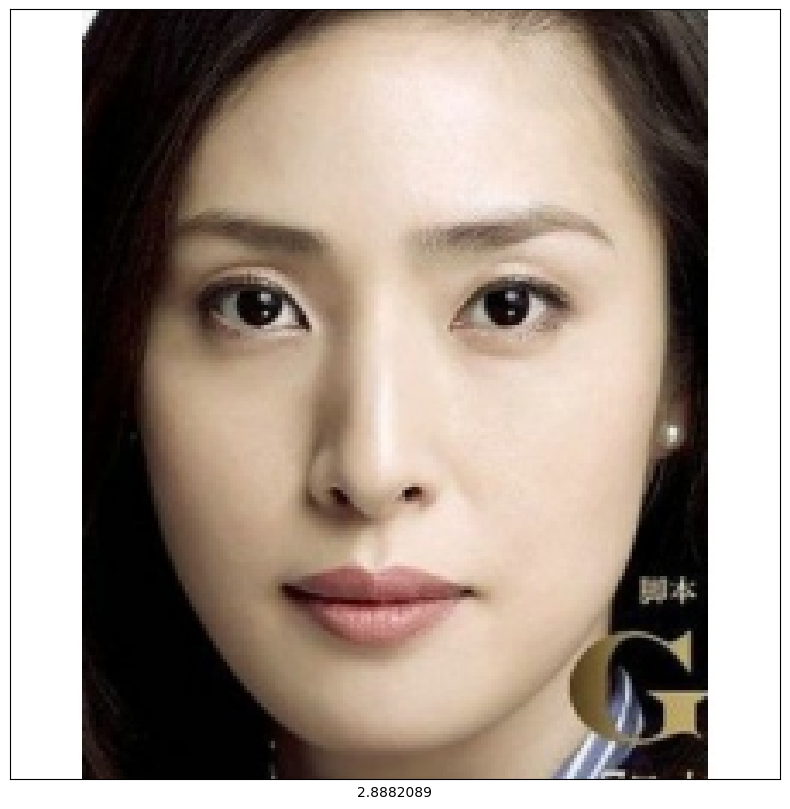

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(X_test[77])
plt.xticks([])
plt.yticks([])
plt.xlabel(test_predictions[0][0])
plt.show()

In [ ]:
y_test[7]

2.516667

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


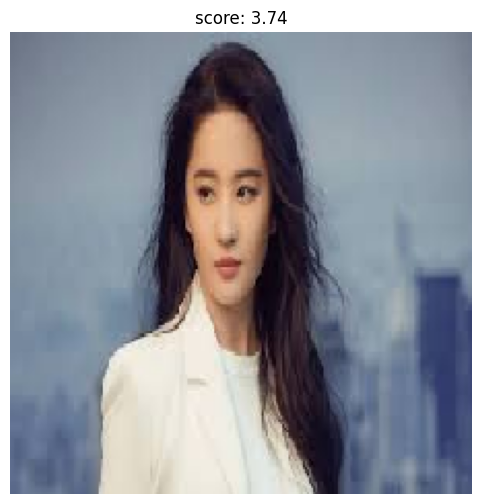

3.7398875

In [ ]:
def predict_beauty_score(image_path, model):
    """
    预测单张图片的美颜分数
    """
    # 1. 加载和预处理图片
    img = tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=(224, 224)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # 2. 预测
    prediction = model.predict(img_array)
    score = prediction[0][0]

    # 3. 显示图片和预测结果
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'score: {score:.2f}')
    plt.show()

    return score

# 使用示例：
score = predict_beauty_score('test.jpeg', model)
score